### what are tools?
it allows the models to connect with the external functions.

### Usecases
1. Fetch extra data to add knowledge
2. take an action like a meeting
3. perform calculation
4. modify the UI. 

## Project - Airline AI Assistant

In [1]:
# imports
import os
from dotenv import load_dotenv
import openai
import gradio as gr
import json

In [2]:
## initialization
load_dotenv()
os.environ['OPENAI_API_KEY']=os.getenv('OPENAI_API_KEY')
MODEL = 'gpt-4o-mini'
openai_client = openai.OpenAI()

In [3]:
## define the system prompt
system_prompt="""
You are a helpful assistant for an Airline called FlightAI.
Give short, concise, and  answers. No more than 1 senetence ever.
Always be accurate. If you are unsure about the answer. Be straightforward about that
"""

In [4]:
def chat(message, history):
    messages = [
        {"role":"system", "content": system_prompt}
    ]
    for user_message, assistant_message in history:
        messages.append({"role": "user", "content":user_message})
        messages.append({"role": "assistant", "content": assistant_message})
    messages.append({"role":"user", "content": message})

    result = openai_client.chat.completions.create(
        model = MODEL,
        messages = messages,
        stream = True
    )
    response = ""
    for chunk in result:
        response+=chunk.choices[0].delta.content or ""
        yield response

In [5]:
gr.ChatInterface(
    fn=chat,
    title="Airline Assistant"
).launch()

/Users/protikmostafa/miniconda3/envs/llms/lib/python3.11/site-packages/gradio/chat_interface.py:345: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [6]:
## making a very generic function
ticket_prices = {
    "london": "$799",
    "paris": "$899",
    "tokyo": "$1400",
    "berlin": "$499"
}

def get_ticket_price(city):
    print(f"tool get_ticket_price called for city {city}")
    city = city.lower()
    return ticket_prices.get(city, "unknown")

In [7]:
get_ticket_price("berlin")

tool get_ticket_price called for city berlin


'$499'

In [8]:
## there is a particular dictionary structure that i srequired to describe our function as a tool

price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a ticket to the destination city. Call this function whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to the city'",
    "parameters":{
        "type": "object",
        "properties":{
            "city":{
                "type": "string",
                "description": "The city the customer is travelling to",
            },
        },
    },
    "required": ["destination_city"],
    "additionalProperties": False
}


## we need to include this in a list of tools
tools = [
    {"type":"function", "function": price_function}
]

In [9]:
def chat(message, history):
    messages = [
        {"role":"system", "content": system_prompt}
    ]
    # old system
    # for human, assistant in history:
    #     messages.append({"role": "user", "content": human})
    #     messages.append({"role": "assistant", "content": assistant})
    for msg in history:
        messages.append(msg)
    messages.append({"role":"user", "content": message})

    result = openai_client.chat.completions.create(
        model = MODEL,
        messages = messages,
        tools = tools
    )
    ## in the next bit, we get the response normally with the choices
    ## in here, we will see that OpenAI will stop and like "I dont have the answer so I want to stop and call tools"

    if result.choices[0].finish_reason=="tool_calls":
        ## message is when OpenAI is asking us to call a tool
        message = result.choices[0].message
        # print(f"OpenAI collecting message: {message}")
        result,city = handle_tool_call(message)
        ## to the messages list of dict, we need to append 2 more rows
        ## 1. the message that OpenAI is asking us to use the tool
        ## 2. the response that we get from the tool
        messages.append(message)
        messages.append(result)
        result = openai_client.chat.completions.create(
            model = MODEL,
            messages = messages
        )
    return result.choices[0].message.content

In [10]:
## now the missing piece from our previous cell: handle_tools_call

def handle_tool_call(message):
    ## the message came back from OpenAI. we need to unpack to see which tool it did it want to call
    # print(f"message: {message}")
    tool_call = message.tool_calls[0]
    # print(f"tool_call = {tool_call}")
    arguments = json.loads(tool_call.function.arguments)
    # print(f"Arguments: {arguments}")
    city = arguments.get('city')
    price = get_ticket_price(city)
    result = {
        "role": "tool",
        "content": json.dumps({"city": city, "price": price}),
        "tool_call_id":message.tool_calls[0].id
    }
    return result, city

In [11]:
gr.ChatInterface(
    fn = chat,
    type = "messages"
).launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


## Go Multimodal
We are going to use DALL-E-3 image generation model behind GPT-4o to generate some images

In [12]:
## some more imports

import base64          # base64 endoding/decoding
from io import BytesIO # In-Memory binary file - writes in RAM
from PIL import Image  # Image utility tool

In [13]:
## we will create a function called Artist. It will call OpenAI and 
## Generate an Image.

def artist(city):
    image_response = openai_client.images.generate(
        model = "dall-e-3",
        prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about the {city}, in a vibrant pop-art style",
        size="1024x1024",
        n=1,
        response_format="b64_json",
    )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

In [14]:
# image = artist("Sydney")
# display(image)

In [15]:
# image = artist("Dhaka")
# display(image)

## Audio
we will create a function that uses OpenAI's speech model to genertae Audio

In [16]:
from pydub import AudioSegment
from pydub.playback import play

def talker(message):
    response = openai_client.audio.speech.create(
        model = "tts-1",
        voice = "onyx",
        input = message
    )

    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)

In [17]:
talker("Hey! Whatchu doin?")

Input #0, wav, from '/var/folders/x7/xysp_t5n7pz6r9vs9x6sjsxm0000gn/T/tmp8gjm4qr0.wav':
  Duration: 00:00:01.10, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   0.92 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

   0.96 M-A: -0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

## Agent Framework

The term 'Agentic AI' or Agentization is an umbrella term that refers to number of techniques, like:
1. Breaking a complex problem into smaller steps, with multiple LLMs carrying out specialized tasks.
2. The ability for LLM to use tools to give them additional capabilities
3. The 'Agent Environment' which allows Agents to collaborate
4. an LLM can act as the planner, dividing bigger tasks into smaller ones for the specialists
5. The concept of an Agent having autonomy/agency, beyond just responding to a prompt - like memory.

In [18]:
## we will demo 1 & 2 here
def chat(message, history):
    image = None
    messages = [
        {"role":"system", "content": system_prompt}
    ]
    for human, assistant in history:
        messages.append({"role":"user", "content": human})
        messages.append({"role":"user", "content": assistant})
    messages.append({"role":"user", "content": message})
    ## this is like passing the bundle of the chat so far 
    response = openai_client.chat.completions.create(
        model = MODEL,
        messages=messages,
        tools=tools
    )
    ## when the model needs help from tools
    ## sometimes the assistant says - i dont know the answer directly. i need to use a tool
    
    if response.choices[0].finish_reason=="tool_calls":
        message = tool_call = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(city)
        response = openai_client.chat.completions.create(
            model = MODEL,
            messages = messages
        )
    reply = response.choices[0].message.content
    talker(reply)
    return reply, image

In [19]:
# more involved gradio code as we are not using off-the-shelf class

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500)
        image_output = gr.Image(height=500)

    with gr.Row():
        msg = gr.Textbox(label = "Chat with our AI assistant: ")

    with gr.Row():
        clear = gr.Button("Clear")

    def user(user_message, history):
        return "", history + [[user_message, None]]

    def bot(history):
        user_message = history[-1][0]
        bot_message, image = chat(user_message, history[:-1])
        history[-1][1] = bot_message
        return history, image

    msg.submit(
        user,
        [msg, chatbot],
        [msg, chatbot],
        queue=False
    ).then(
        bot,
        chatbot,
        [chatbot, image_output]
    )
    clear.click(lambda: None, None, chatbot, queue=False)

ui.launch()

/var/folders/x7/xysp_t5n7pz6r9vs9x6sjsxm0000gn/T/ipykernel_6802/1137242215.py:5: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(height=500)


* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


In [20]:
## we will create a function called Artist. It will call OpenAI and 
## Generate an Image.

def selftry(prompt):
    image_response = openai_client.images.generate(
        model = "dall-e-3",
        prompt=prompt,
        size="1024x1024",
        n=1,
        response_format="b64_json",
    )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

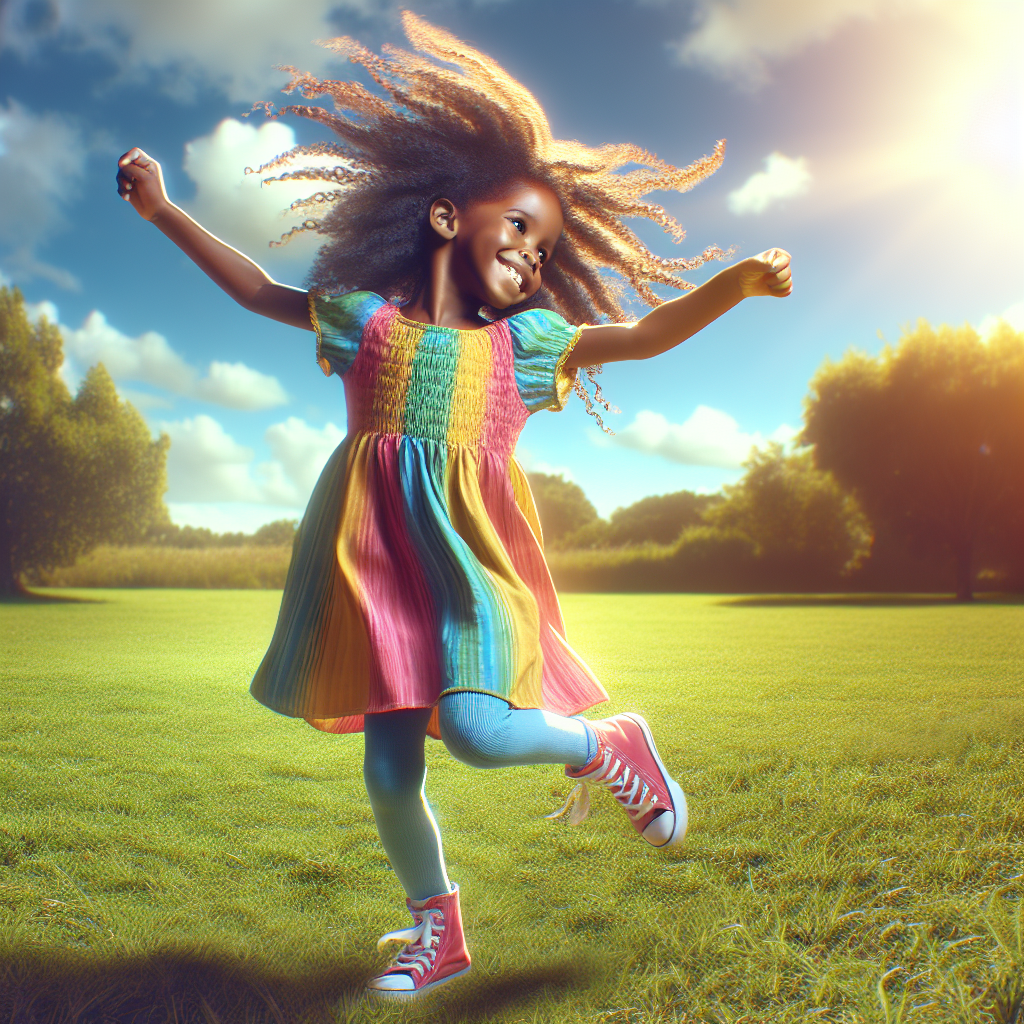

tool get_ticket_price called for city Sydney


Input #0, wav, from '/var/folders/x7/xysp_t5n7pz6r9vs9x6sjsxm0000gn/T/tmpj9pktqli.wav':
  Duration: 00:00:03.12, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   3.02 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 


tool get_ticket_price called for city dhaka


Input #0, wav, from '/var/folders/x7/xysp_t5n7pz6r9vs9x6sjsxm0000gn/T/tmptpbuoz82.wav':
  Duration: 00:00:02.88, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   2.77 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

In [21]:
user_prompt = """
show me a photo of a kid dancing
"""
image = selftry(user_prompt)
display(image)